In [1]:
import scvi
import scgen
import rpy2
import scib
import anndata
import logging
import warnings
import scanorama
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import scrublet as scr
import doubletdetection
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from anndata import AnnData
from os import PathLike, fspath

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` n

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
# #Note: this can be commented out to get more verbose R output
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython


warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
rcParams['figure.figsize']=(5,5) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
adjustText                  NA
anndata2ri                  1.1
annoy                       NA
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
chex                        0.1.5
cloudpickle                 2.2.0
colorama                    0.4.4
contextlib2                 NA
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy    

# **Reading in the data**

In [4]:
adata_query = {}
batch_keys = ['allen_mtg']

for key in batch_keys:
    
    print('----------------------------')
    print(f'Fetching {key.upper()} data')
    print('----------------------------')

    adata_query[key] = sc.read_h5ad(f'../data/processed/{key}/{key}_annotated_anndata.h5ad')
    print(adata_query[key])

----------------------------
Fetching ALLEN_MTG data
----------------------------
AnnData object with n_obs × n_vars = 104349 × 17950
    obs: 'ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes', 'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId', 'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype', 'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem', 'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x', 'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x', 'species_x', 'specimenID', 'study', 'tissue_x', 'path', 'error', 'individualID_y', 'specimenIdSource', 'organ_y', 'tissue_y', 'BrodmannArea', 'sampleStatus', 'tissueWeight', 'tissueVolume', 'nucleicAcidSource_y', 'cellType', 'fastingState', 'isPostMortem', 'samplingAge', 'samplingAgeUnits', 'visitNumber', 'assay_y', 'individualID', 'dataset', 'individualIdSource', 'species_y', 'sex_y', 'race', 'ethnicity', 'yearsEducation', 'ageDeath'

## **Batch Effect**

From our previous analysis we observe obvious batch effects in the `Leng ETC and SFG` data, as certain cluster of cells are overrepresented with replicates from a single individual and across a single Braak stage. This overrepresnted clusters could potentially confound the cluster annotation which qwe previously estimated using standard protocols in scanpy. Since the cluster lables are critical fo downstream tasks, we need to perform batch correction to adjust for batch effects from the samples.

Correcting for this batch effect will regress out any technical differences between samples, while preserving the biological variation. We allow for this to optimally cluster and annotate the data. 

The goal is to make the cell labels consistent between the datasets, since we have previously annotated the studies independently. This has the problem that we can’t be sure that the labeling (`stratification`) puts e.g. ‘Excitatory cells’ on a consistent population in the datasets. It is possible that classical cell type markers are perturbed diffentially in each study and condition. 

This approach can also be helpful to find differentiation trajectories, but we revert back to non-batch-corrected data for differential testing/pathway analysis and computing marker genes.


## **2.3 Batch Correction and Query Integration**

To regress out more complex techincal variation that might exist in the batches presented in the data, we employ deep-learning based pareametric approaches that have been shown to perform well on complex integration tasks while preserving biological variation of the sub-species within the data set. 

In particular, the `Scanorama`, `single-cell Variational Inference (scVI and scANVI)`, `single-cell Generative modelling (scGEN)` approacges have been shown to efficiently remove/adjust for batch effects while conserving biological variation on single-cell RNA seq data in the `human immune cell atlas`. However, these methods differentially removed batch effects and conserved biologicala variation. For example, while `Scanorama` and `scVI`balance the t    wo objectives on complex integration tasks, `scANVI` exhibited residual batch structure in `Smart-seq2` but preserved biological variation most strongly. Although `scGEN` produced poor conservation of cell state trajectories, it was particularly adept at removing biological variation confounded with batch effects. Considering the wide variabily in performance of these methods, we therefore evaluate the performance of each of these methods on the query data using bio-conservation and batch removal metrics described in the [**Malte D. Luecken. et. al**](https://doi.org/10.1038/s41592-021-01336-8)

In addition, these methods were shown to be sensitive to preprocessing steps like `scaling` (genes have zero mean and unit variance) and `highly variable genes (HVG)` selection. Generally, integration with `HVG` selection generally outperformed data integration of the full gene set, whereas `scaling` led methods to prioritize batch removal over bio-conservation, although this was dependent on the methods used. Deu to limited resources, we used the suggested combination of `HVG` selection and `scaling` for `scGEN`, `scVI`, `scANVI`, and `scGEN` in [**Malte D. Luecken. et. al**](https://doi.org/10.1038/s41592-021-01336-8). However, [**Malte D Luecken & Fabian J Theis**](https://www.embopress.org/doi/full/10.15252/msb.20188746) note that there is currently no consensus on whether scaling over genes is informative or retains much biological information about the data. 

Indeed, we observe a degree of batch/technical effects in the some of the studies. While the `Leng` and `Mathys` studies show no strong technical effects on certain covaraites, the `Grubman` study shows strong batch, sample, and sex effects relative to cell type annotations. As a result, we employ the integration techniques higlighted above to regress out the batch effects in the studies presented while simultaneously outputing a common embedding.

### **Reference mapping with scvi-tools(scANVI)**

To resolve the batch effect across the studies, we map cell types from the studies onto a refence atlas from the `Allen Brain Map` containing nuclei from [**Human Multiple Cortical Areas SMART-seq reference**](https://portal.brain-map.org/atlases-and-data/rnaseq/human-multiple-cortical-areas-smart-seq). 

This workflow is comuputed usin the [**scANVI workflow for reference mapping**](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html).

In this this workflow, we train a Deep Generative Variational Autoencoder Model on the reference data and transfer latent representations and cluster annotations to new samples (called query). The goal is to analyze these samples in the context of the reference, by mapping the query cells to the same reference latent space.

In [5]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
Global seed set to 94705
/Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### **Get Reference data**

In [6]:
adata_reference = sc.read_h5ad(f'../data/raw/human_multiple_cortical_areas_smart_seq/anndata.h5ad')
set_covariate_keys = False
print(adata_reference)

# adata_reference = sc.read_h5ad(f'../data/raw/SEA-AD/Reference_MTG_RNAseq_final-nuclei.2022-06-07.h5ad')
# print(adata_reference)


AnnData object with n_obs × n_vars = 47432 × 50281
    obs: 'exp_component_name', 'specimen_type', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_order', 'full_genotype_label', 'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color', 'region_order', 'region_label', 'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_order', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_order', 'cell_type_designation_label', 'external_donor_name_color', 'external_donor_name_order', 'external_donor_name_label', 'outlier_call', 'outlier_type'
    var: 'chromosome', 'entrez_id', 'gene_name', 'm

### **Dataset preprocessing**

This dataset was already processed as described in the [**protocols**](https://portal.brain-map.org/atlases-and-data/rnaseq/protocols-human-cortex). Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy.

For scVI and scANVI it is recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the adata.raw object. We obtain variable genes from each dataset and take their intersections.

#### **HVG Selection**

We run highly variable gene selection on the reference data and use these same genes for the query data.

In [7]:
sc.pp.highly_variable_genes(adata_reference, n_top_genes=3000, batch_key = 'region_label', subset=True, flavor='seurat_v3')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


#### **Filter genes in query and reference data**

In [8]:
eval_string = []

for study in adata_query.keys():
    eval_string.append(f'set(adata_query["{study}"].var_names)')

eval_string = '&'.join(eval_string)    
gene_names = list(eval(eval_string) & set(adata_reference.var_names))

adata_reference = adata_reference[:, gene_names]
                                  

for study in adata_query.keys():
    
    print('--------------------------------------')
    print(f'Subsetting HVGs in {study.upper()} data')
    print('--------------------------------------')
    
    adata_query[study] = adata_query[study][:, gene_names]

--------------------------------------
Subsetting HVGs in ALLEN_MTG data
--------------------------------------


### **Train reference**

We train the reference using the standard SCVI workflow, except we add a few non-default parameters that were identified to work well with scArches.

In [9]:
adata_reference.layers['counts'] = adata_reference.X

if set_covariate_keys:
    scvi.model.SCVI.setup_anndata(adata_reference, batch_key="region_label", layer="counts",
                                categorical_covariate_keys=["sample_name", "donor_sex_label"],
                                continuous_covariate_keys=["n_genes"])
else:
    scvi.model.SCVI.setup_anndata(adata_reference, batch_key="region_label", layer="counts",)

In [10]:
train = input('Do you want to train a new scvi-model? (True/False): ')

In [11]:
if eval(train.capitalize()): 
    
    arches_params = dict(
                    use_layer_norm="both",
                    use_batch_norm="none",
                    encode_covariates=True,
                    dropout_rate=0.2,
                    n_layers=2,
                    )
    
    trainer_kwargs = dict(max_epochs=100,
                          early_stopping = True,
                          early_stopping_patience = 25,
                          early_stopping_mode = "min",
                          enable_progress_bar = True,
                          )

    vae_ref = scvi.model.SCVI(adata_reference, **arches_params)
    vae_ref.train(**trainer_kwargs)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [27:57<00:00, 16.42s/it, loss=2.2e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [27:57<00:00, 16.77s/it, loss=2.2e+03, v_num=1]


`SCANVI` tends to perform better in situations where it has been initialized using a pre-trained SCVI model. In this case, we will use `vae_ref` that we have already trained above.

In [12]:
adata_reference.obs["labels_scanvi"] = adata_reference.obs.cluster_label.apply(lambda x: x.split(' ')[0])
adata_reference.obs["labels_scanvi"] = adata_reference.obs["labels_scanvi"].map({'Exc': 'Excitatory',
                                                                            'Inh': 'Inhibitory',
                                                                            'Astro': 'Astrocyte',
                                                                            'Endo': 'Endothelial', 
                                                                            'Micro': 'Microglia', 
                                                                            'OPC': 'OPC', 
                                                                            'Oligo': 'Oligodendrocyte', 
                                                                            'Peri': 'Pericytes',
                                                                            'VLMC': 'VLMC'})
adata_reference.obs["labels_scanvi"] = adata_reference.obs["labels_scanvi"].astype('category')

In [13]:
dir_path_scan = "../models/reference_mapping/allen_reference/"

if eval(train.capitalize()):
    vae_ref_scan = scvi.model.SCANVI.from_scvi_model(vae_ref,
                                                unlabeled_category="Unknown",
                                                labels_key="labels_scanvi",)
    vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)
    vae_ref_scan.save(dir_path_scan, overwrite=True)
else:
    vae_ref_scan = scvi.model.SCANVI.load(dir_path_scan, adata=adata_reference)

INFO     Training for 20 epochs.                                                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [09:10<00:00, 25.71s/it, loss=2.26e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [09:10<00:00, 27.53s/it, loss=2.26e+03, v_num=1]


Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [14]:
adata_reference.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()

sc.pp.neighbors(adata_reference, use_rep="X_scANVI")
sc.tl.leiden(adata_reference)
sc.tl.umap(adata_reference)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
running Leiden clustering
    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


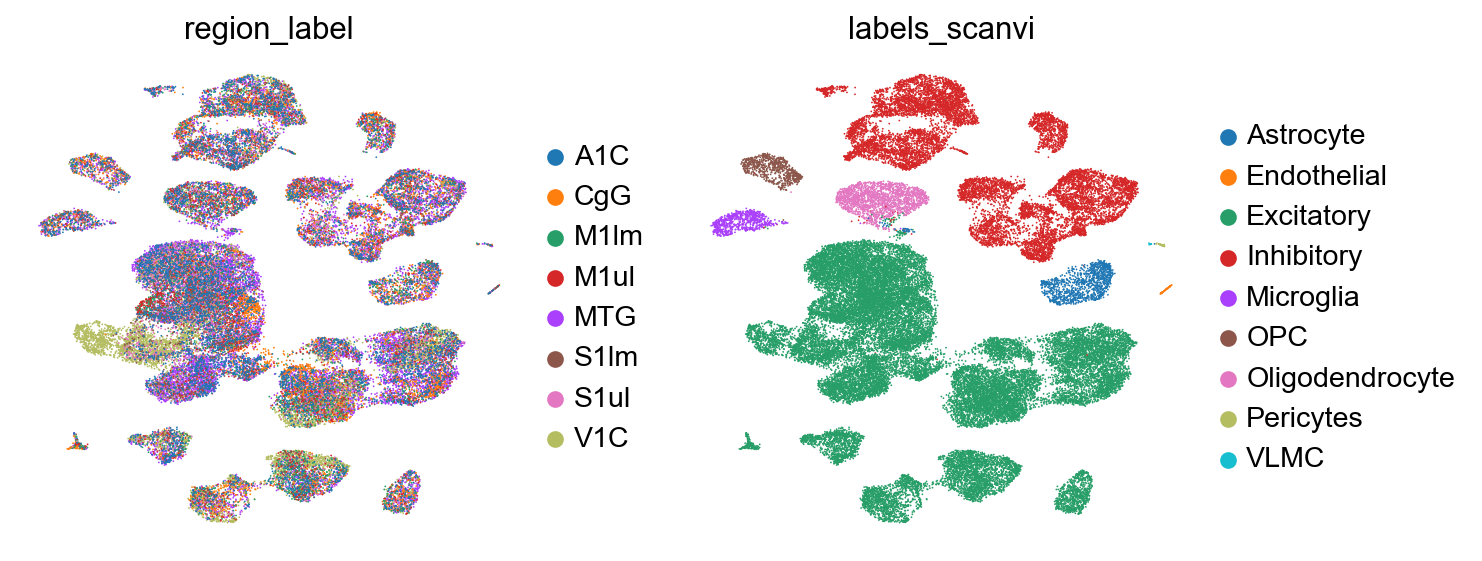

In [15]:
sc.pl.umap(
    adata_reference,
    color=["region_label", "labels_scanvi"],
    frameon=False,
    ncols=2,
)

### **Update with query**

We can load a new model with the query data either using

1. The saved reference model

2. The instance of the reference model

In [16]:
def label_transfer(adata_q: AnnData,
                   model_dir_path: str = "../models/reference_mapping/allen_reference/",
                   train_kwargs: dict = dict(use_gpu=False,
                                            batch_size=64,
                                            early_stopping=True, max_epochs=100, 
                                            early_stopping_min_delta=100,
                                            early_stopping_patience=15, 
                                            early_stopping_mode='min') 
                   ):
    adata_q = adata_q.copy()
    scvi.model.SCANVI.prepare_query_anndata(adata_q, model_dir_path)

    vae_q = scvi.model.SCANVI.load_query_data(adata_q, model_dir_path)
    vae_q.train(max_epochs=100, plan_kwargs=dict(weight_decay=0.0),check_val_every_n_epoch=10)

    adata_q.obsm["X_scANVI"] = vae_q.get_latent_representation()
    adata_q.obs["predictions"] = vae_q.predict()

    return adata_q

In [17]:
train_kwargs=dict(max_epochs=100, 
                  use_gpu=False, 
                  batch_size=64, 
                  early_stopping=True,
                  early_stopping_min_delta=100, 
                  early_stopping_patience=15, 
                  early_stopping_mode='min') 

for study in adata_query.keys():

    print('----------------------------------------------------')
    print(f'Transferring labels to {study.upper()} data')
    print('----------------------------------------------------')
    
    adata_query[study].obs['region_label'] = study.split('_')[-1].upper()
    adata_query[study] = label_transfer(adata_query[study],
                                        model_dir_path = "../models/reference_mapping/allen_reference/",
                                        train_kwargs = train_kwargs)


----------------------------------------------------
Transferring labels to ALLEN_MTG data
----------------------------------------------------
INFO     File ../models/reference_mapping/allen_reference/model.pt already downloaded        
INFO     Found 100.0% reference vars in query data.                                          
INFO     File ../models/reference_mapping/allen_reference/model.pt already downloaded        
INFO     Training for 100 epochs.                                                            


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [1:15:46<00:00, 41.77s/it, loss=847, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:15:46<00:00, 45.46s/it, loss=847, v_num=1]


## **Analyze reference and query**

In [18]:
adata_full = adata_reference.copy()

for study in adata_query.keys():

    print('----------------------------------------------------')
    print(f'Adding {study.upper()} data')
    print('----------------------------------------------------')

    adata_query[study].obs['labels_scanvi'] = adata_query[study].obs.predictions.copy()
    adata_full = adata_query[study].concatenate(adata_full)

----------------------------------------------------
Adding ALLEN_MTG data
----------------------------------------------------


In [19]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:27)


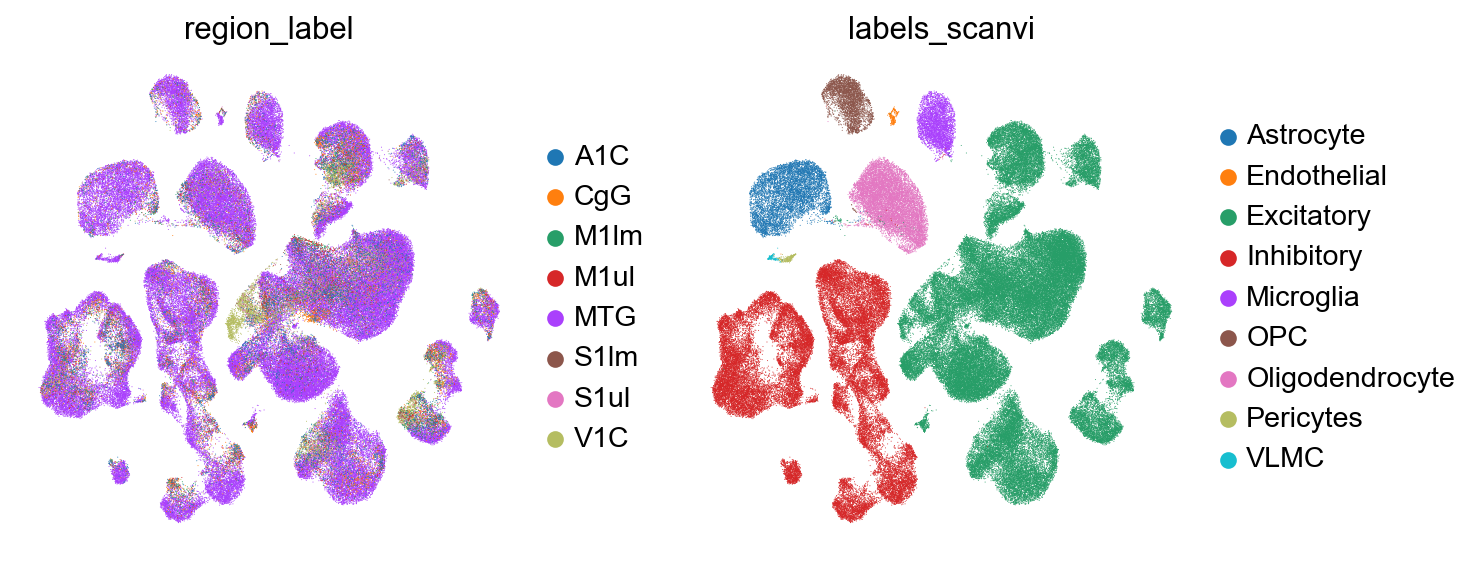

In [20]:
sc.pl.umap( adata_full, color=["region_label", "labels_scanvi"], frameon=False, ncols=2)

----------------------------------------------------
UMAP of ALLEN_MTG data
----------------------------------------------------


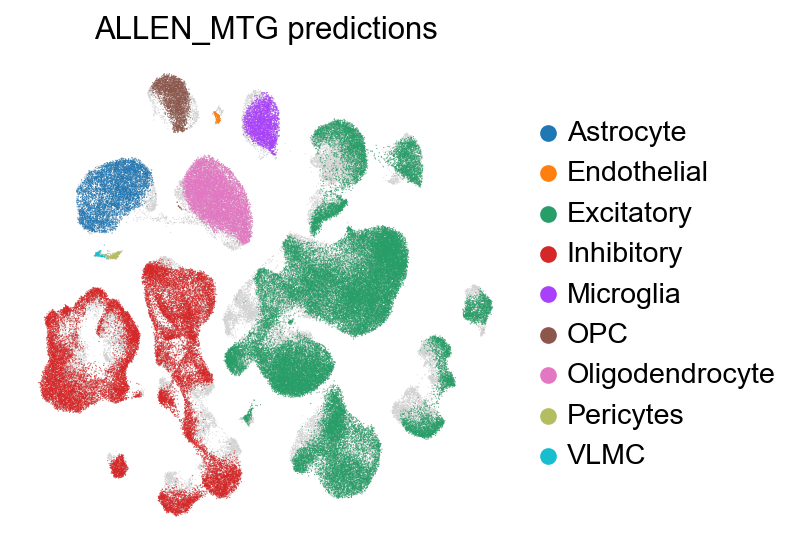

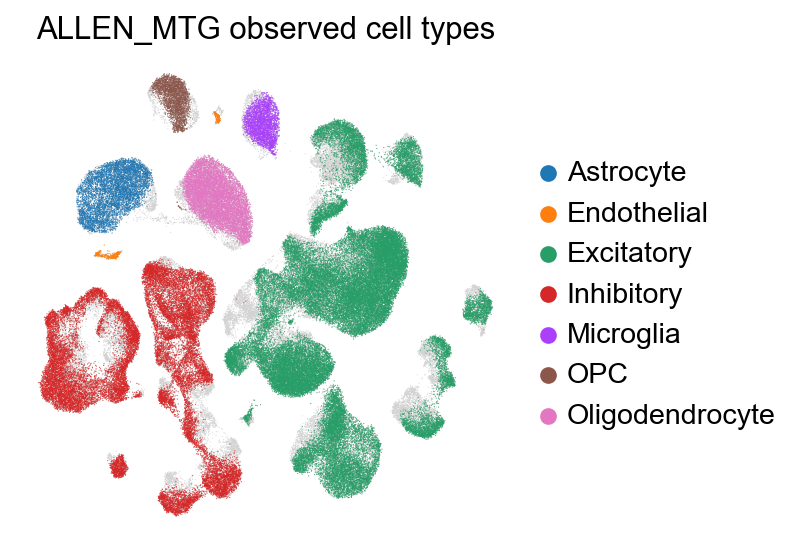

In [21]:

for study in adata_query.keys():

    print('----------------------------------------------------')
    print(f'UMAP of {study.upper()} data')
    print('----------------------------------------------------')

    ax = sc.pl.umap(adata_full, frameon=False, show=False,)

    sc.pl.umap(adata_full[: adata_query[study].n_obs], color=["predictions"],
               frameon=False, title=f"{study.upper()} predictions", ax=ax, alpha=0.7)


    ax = sc.pl.umap(adata_full, frameon=False, show=False,)

    sc.pl.umap(adata_full[: adata_query[study].n_obs], color=["cell_type"], frameon=False,
               title=f"{study.upper()} observed cell types",
               ax=ax, alpha=0.7,)

# **Saving the data**

In [22]:

for study in adata_query.keys():
    
    print('----------------------------')
    print(f'Saving {study.upper()} data')
    print('----------------------------')

    adata_load = sc.read_h5ad(f'../data/processed/{study}/{study}_annotated_anndata.h5ad')
    adata_load.obs['predictions'] = adata_query[study].obs.predictions.copy()
    adata_load.obsm["X_scANVI"] = adata_query[study].obsm["X_scANVI"].copy()
    adata_load.write_h5ad(f'../data/processed/{study}/{study}_mapped_anndata.h5ad')

----------------------------
Saving ALLEN_MTG data
----------------------------


In [23]:
adata_reference.write('../data/raw/human_multiple_cortical_areas_smart_seq/mapped_anndata.h5ad')